# Deep Deterministic Policy Gradient for Portfolio Management

**Steps to try:**
1. We first try to overfit a 3 stocks toy case using 3 years of training data.
2. Try to generalize to other years of the same stock.
3. Get some insigts on network topology and hyperparameter tuning.
4. Increase the number of stocks. (Increase action space to more than 10.)

**Possible improvement methods:**
1. Use correlated action noise
2. Use adaptive parameter noise

**Figures to show:**
1. Training: total rewards w.r.t episode
2. How the model performs on training data
3. How the model performs on testing data

## Setup

In [1]:
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
# for compatible with python 3
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# force tensorflow to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
num_training_time = history.shape[1]
num_testing_time = history.shape[1]
window_length = 3

In [4]:
# get target history
target_stocks = ['AAPL', 'COST', 'DISH']
nb_classes = len(target_stocks) + 1
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

In [16]:
# collect testing data
testing_stocks = ['CMCSA', 'GOOGL', 'EBAY']
testing_history = np.empty(shape=(len(testing_stocks), num_testing_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), :num_testing_time, :]

In [17]:
print(target_history.shape)
print(testing_history.shape)

(3, 1825, 4)
(3, 1825, 4)


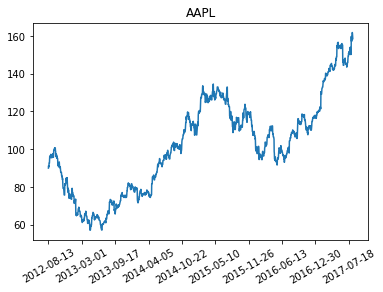

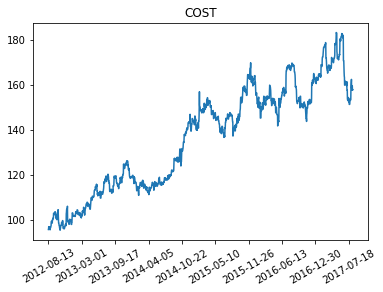

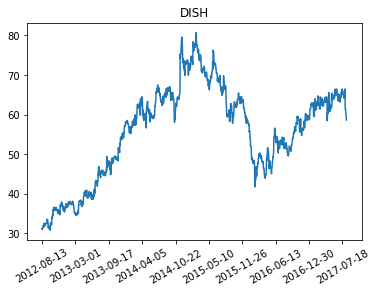

In [7]:
# visualize 3 stock open price
date_list = [index_to_date(i) for i in range(target_history.shape[1])]
x = range(target_history.shape[1])
for i in range(len(target_stocks)):
    plt.figure(i)
    plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
    plt.xticks(x[::200], date_list[::200], rotation=30)
    plt.title(target_stocks[i])
    plt.show()

In [8]:
from environment.portfolio import PortfolioEnv

In [9]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer

In [ ]:
tf.reset_default_graph()

In [10]:
# instantiate environment, 3 stocks, with trading cost, window_length 50, start_date sample each time
env = PortfolioEnv(target_history, target_stocks, steps=1500, window_length=window_length)
sess = tf.Session()
action_dim = [nb_classes]
state_dim = [nb_classes, window_length]
batch_size = 64
action_bound = 1.
tau = 1e-3
actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size)
critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                     learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars())
actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

ddpg_model = DDPG(env, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                  config_file='config/stock.json', model_save_path='weights/stock/checkpoint.ckpt',
                  summary_path='results/stock/')
ddpg_model.initialize(load_weights=True, verbose=False)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


[2017-11-19 22:44:57,676] From /Applications/anaconda/lib/python2.7/site-packages/tflearn/initializations.py:119: __init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


INFO:tensorflow:Restoring parameters from weights/stock/checkpoint.ckpt


[2017-11-19 22:45:00,086] Restoring parameters from weights/stock/checkpoint.ckpt


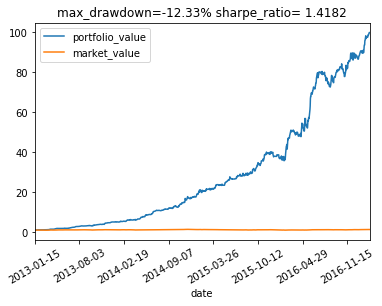

In [11]:
# evaluate the model with training data
observation, info = env.reset()
done = False
while not done:
    action = ddpg_model.predict_single(observation)
    observation, _, done, _ = env.step(action)
env._render()

In [28]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = PortfolioEnv(testing_history, testing_stocks, steps=365, window_length=window_length, 
                   sample_start_date='2013-08-15')

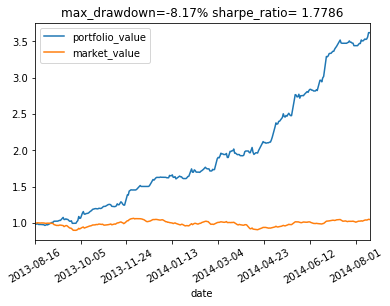

In [29]:
# test on DDPG
observation, info = env.reset()
done = False
while not done:
    action = ddpg_model.predict_single(observation)
    observation, _, done, _ = env.step(action)
env._render()

In [30]:
from model.supervised.imitation_optimal_action import *

Using TensorFlow backend.


In [38]:
# test on imitation learning
optimal_given_past_model = create_network_give_past(17, 3)

Model load successfully
